# Setup

In [ ]:
# !pip install -q -U transformers diffusers accelerate safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.9 MB/s eta 0:00:00


In [2]:
# Standard library imports
import os

# Third-party imports
import torch
from diffusers import (
    AutoencoderKL,
    StableDiffusionXLPipeline
)
from PIL import Image

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [12]:
class CFG:
    model = "stabilityai/stable-diffusion-xl-base-1.0"
    vae = "madebyollin/sdxl-vae-fp16-fix"
    dtype = torch.float16
    device = "cpu"
    variant = "fp16"
    seed = 42
    howmany = 1
    infsteps = 40

if torch.backends.mps.is_available():
    CFG.device = "mps"
if torch.cuda.is_available():
    CFG.device = "cuda"

print("Device: ", CFG.device)

# fix randomness
g = torch.Generator(device = CFG.device).manual_seed(CFG.seed)

Device:  cuda


In [4]:
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

# Dodatkowe funkcje

In [5]:
# helper function - taken from https://www.datacamp.com/tutorial/fine-tuning-stable-diffusion-xl-with-dreambooth-and-lora

def image_grid(imgs, rows, cols, resize= 512):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]

    w, h = imgs[0].size
    grid_w, grid_h = cols * w, rows * h
    grid = Image.new("RGB", size=(grid_w, grid_h))

    for i, img in enumerate(imgs):
        x = i % cols * w
        y = i // cols * h
        grid.paste(img, box=(x, y))

    return grid

# Budowa modelu

## Inicjalizacja dekodera VAE dla Stable Diffusion XL

Ten fragment kodu odpowiada za **inicjalizację dekodera VAE** (Variational Autoencoder), który jest kluczowym elementem modelu **Stable Diffusion XL**. Dekoder VAE odgrywa ważną rolę w przekształcaniu ukrytych reprezentacji (latent space) na finalne obrazy.

---

### 🔹 **AutoencoderKL**

- **`AutoencoderKL`** to specjalna architektura dekodera używana w Stable Diffusion.
- Jego zadaniem jest **rekonstrukcja obrazów** z ukrytych reprezentacji, które zostały wygenerowane przez model dyfuzyjny.
- To właśnie dzięki niemu model jest w stanie przekształcić wygenerowane dane na rzeczywiste obrazy o wysokiej jakości.

---

### 🔹 **Ładowanie wstępnie wytrenowanego modelu**

- **`.from_pretrained()`**: Funkcja ta **ładuje wstępnie wytrenowany model VAE** ze ścieżki określonej w `CFG.vae`.
- W tym przypadku jest to **optymalizowana wersja dekodera od `madebyollin`**, która działa w precyzji FP16.
- Wybrany dekoder rozwiązuje niektóre problemy z oryginalnym VAE modelu **SDXL** przy pracy z precyzją FP16, zapewniając lepszą jakość generowanych obrazów.

---

### 🔹 **Parametry konfiguracji**

1. **`torch_dtype = CFG.dtype`**:
   - Ustawia typ danych na **float16 (FP16)** zgodnie z wcześniejszą konfiguracją.
   - **FP16** oznacza 16-bitową precyzję liczb zmiennoprzecinkowych.
   - Jest to **kompromis między dokładnością a wydajnością**:
     - Zużywa **mniej pamięci GPU** i przyspiesza obliczenia.
     - Choć mniej dokładna niż standardowe 32 bity, jest wystarczająco precyzyjna dla większości zadań generatywnych.

2. **`variant="fp16"`**:
   - Określa, że używana jest wersja modelu zoptymalizowana dla **FP16**.
   - Dzięki temu model działa szybciej i zużywa mniej pamięci, co jest kluczowe przy pracy z dużymi modelami generatywnymi.

---

### 🔹 **Optymalizacja i wydajność**

- Użyty tutaj dekoder VAE to **specjalnie zoptymalizowana wersja**, która poprawia wydajność oraz jakość generowanych obrazów.
- **Optymalizacja komponentów** (takich jak dekoder VAE) jest kluczowa przy pracy z dużymi modelami generatywnymi, ponieważ pozwala na lepsze wykorzystanie zasobów sprzętowych.


In [6]:
# initialize the pipe
vae = AutoencoderKL.from_pretrained(CFG.vae ,torch_dtype = CFG.dtype)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [7]:
pipe = StableDiffusionXLPipeline.from_pretrained(
    CFG.model,
    vae=vae,
    generator = g,
    torch_dtype = CFG.dtype,
    variant= CFG.variant,
    use_safetensors=True).to(CFG.device)

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder_2%2Fconfig.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer_2%2Fspecial_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2%2Ftokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Keyword arguments {'generator': <torch._C.Generator object at 0x7e84aa9aa250>} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

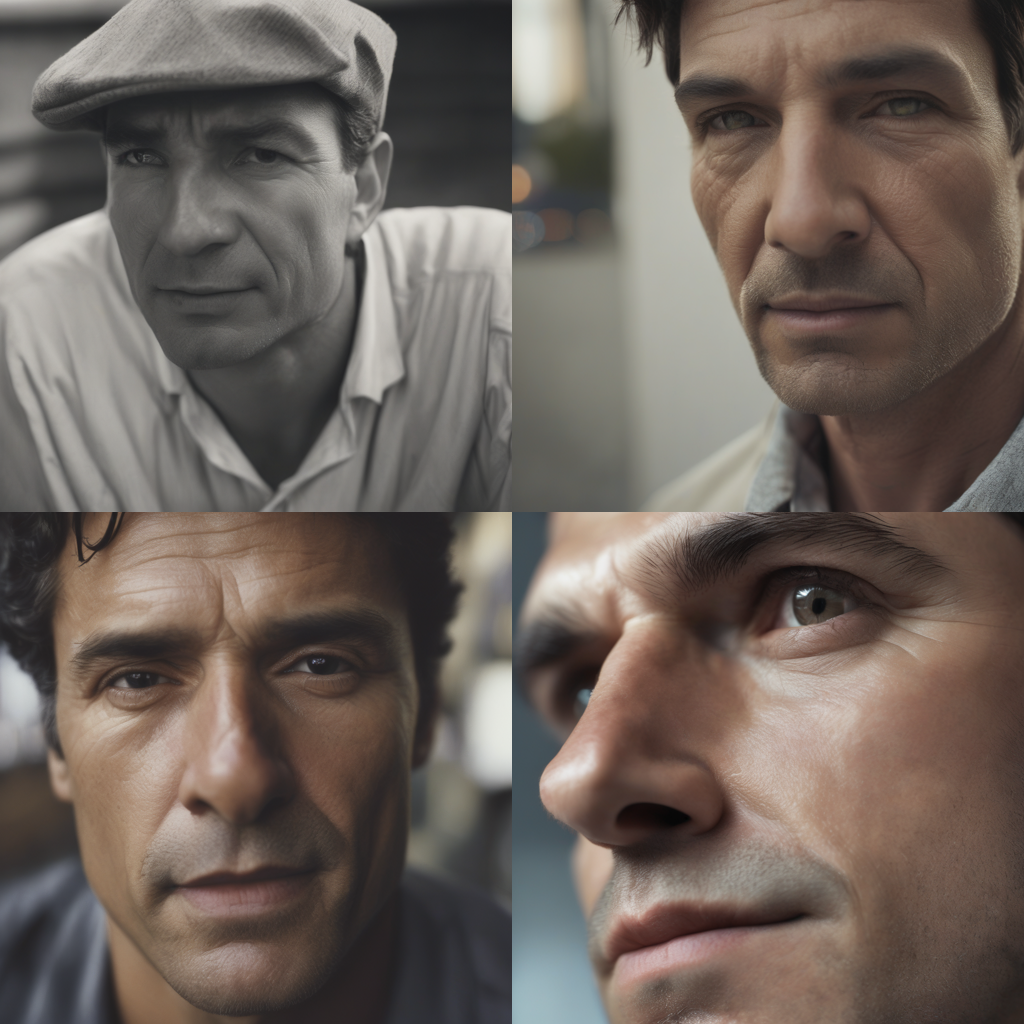

In [13]:
prompt = "High-definition, cinematic, close-up photograph of a man"
images = pipe(prompt=prompt, num_inference_steps = CFG.infsteps,
              num_images_per_prompt = 4)
image_grid(images.images, 2, 2)

## Prompt Negatywny w Generowaniu Obrazów z Stable Diffusion XL

Ten fragment kodu wprowadza **koncepcję promptu negatywnego** w procesie generowania obrazów za pomocą modelu **Stable Diffusion XL**. Jest to zaawansowana technika umożliwiająca bardziej precyzyjną kontrolę nad szczegółami wygenerowanego obrazu.

---

### 🔹 **Czym jest prompt negatywny?**

- **Prompt negatywny** to opis cech, których **nie chcemy** zobaczyć na wygenerowanym obrazie.
- Używany jest jako dodatkowy parametr w modelu generatywnym, aby **aktywnie unikać niepożądanych elementów**.
- Można go porównać do pracy rzeźbiarza:
  - **Prompt pozytywny** określa, co ma być dodane i jakie szczegóły mają się pojawić.
  - **Prompt negatywny** wskazuje, co powinno zostać **usunięte lub pominięte**.

  0%|          | 0/40 [00:00<?, ?it/s]

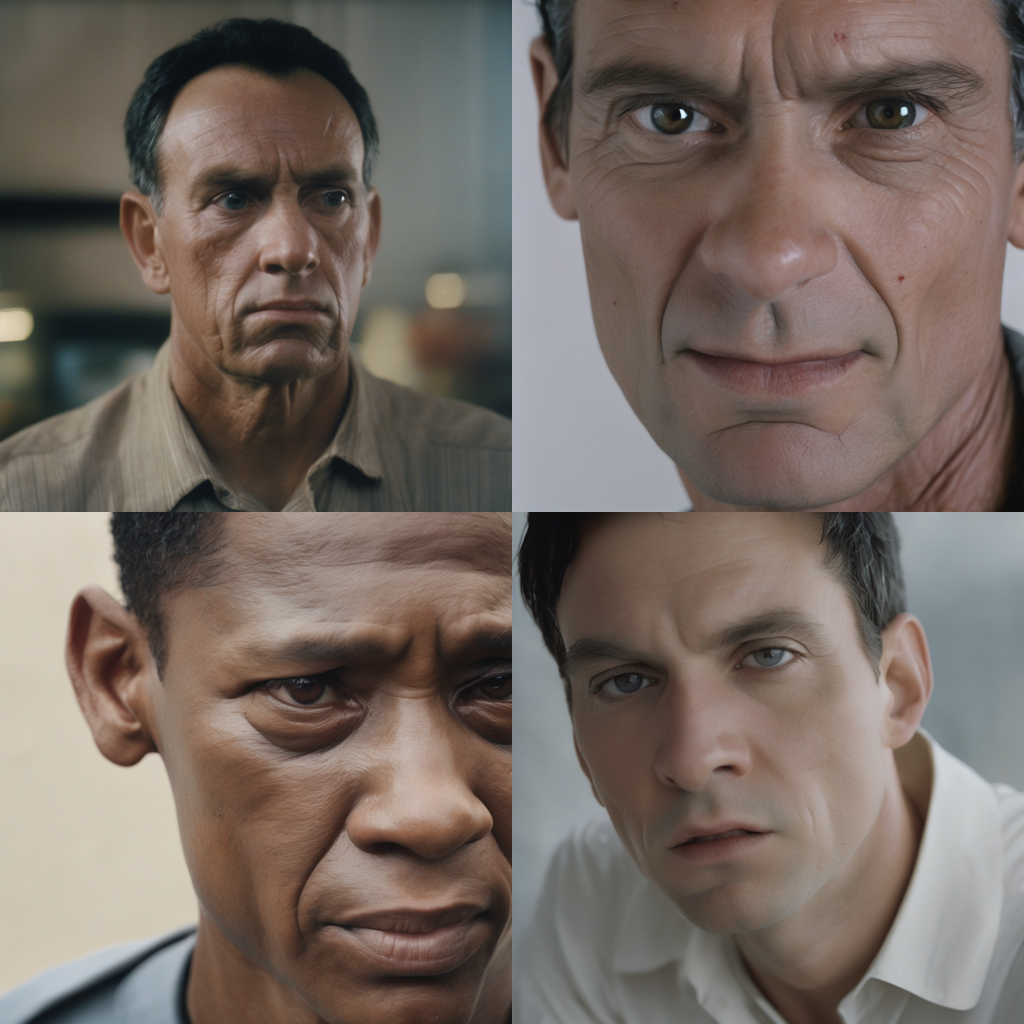

In [14]:
neg_prompt = "moustache, beard, facial hair"

images = pipe(prompt=prompt, negative_prompt = neg_prompt,
             num_inference_steps= CFG.infsteps, num_images_per_prompt = 4)

image_grid(images.images, 2, 2)

## Example 2

  0%|          | 0/40 [00:00<?, ?it/s]

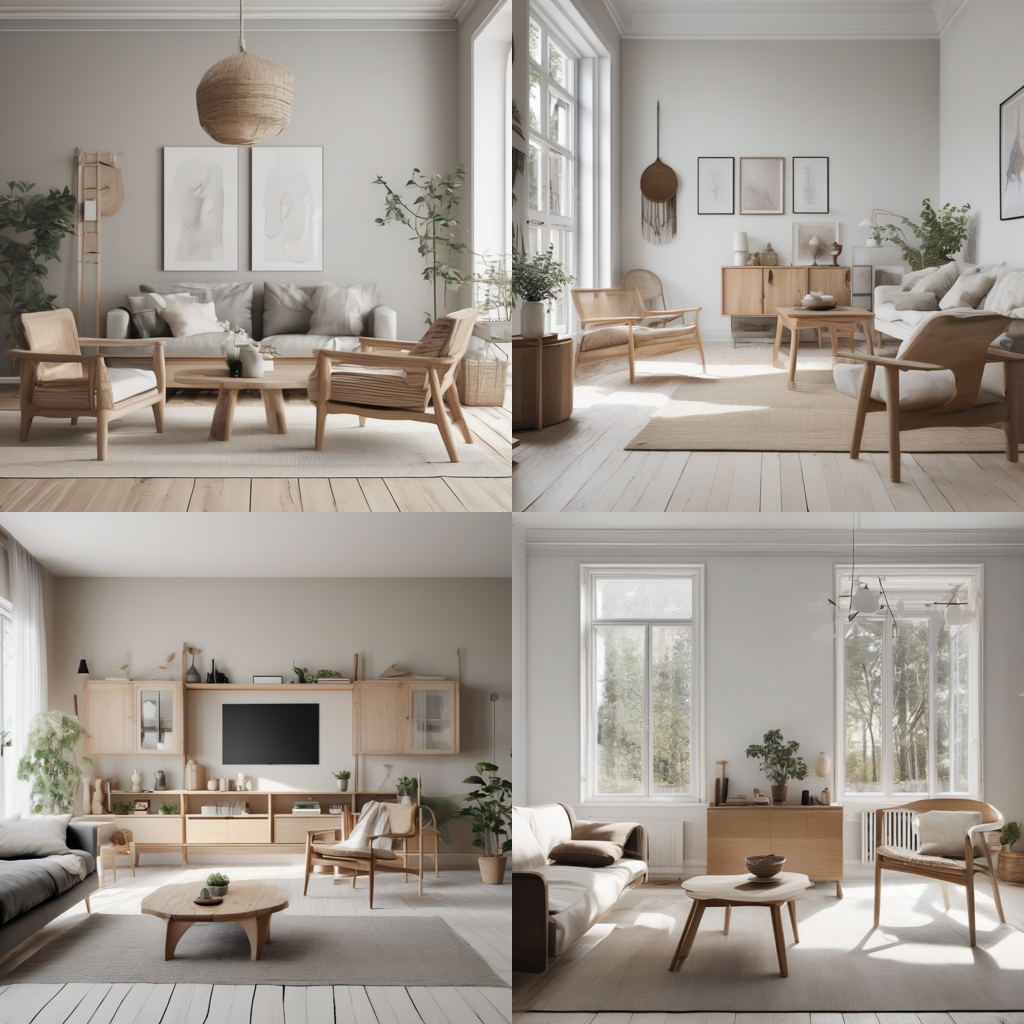

In [15]:
# example prompt from https://x.com/WorldEverett/status/1812540956987592920

prompt = "Minimalist Scandinavian living room with natural light and wooden furniture"
images = pipe(prompt=prompt, num_inference_steps = CFG.infsteps, num_images_per_prompt = 4)
image_grid(images.images, 2, 2)

  0%|          | 0/40 [00:00<?, ?it/s]

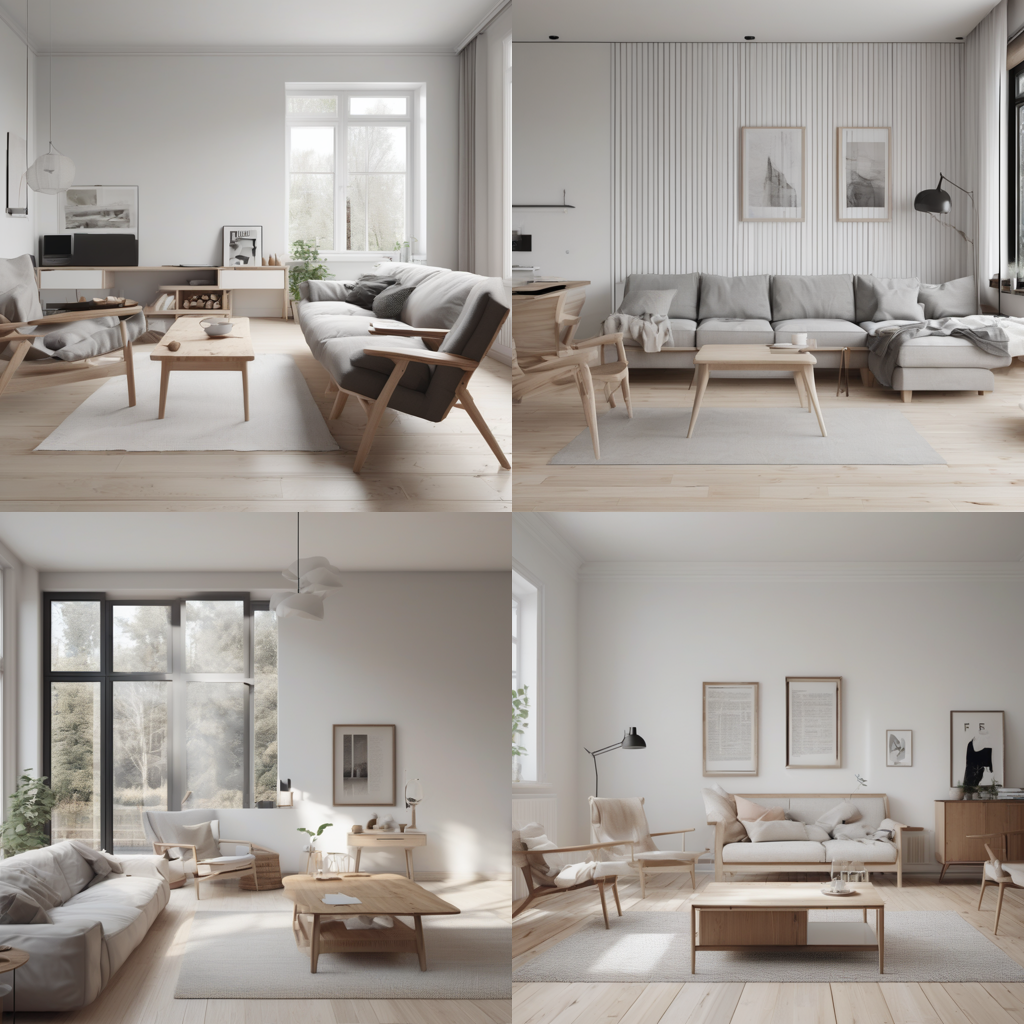

In [16]:
neg_prompt = "plants, lamps, pillows"

images = pipe(prompt=prompt, negative_prompt = neg_prompt,
             num_inference_steps = CFG.infsteps, num_images_per_prompt = 4)

image_grid(images.images, 2, 2)